In [1]:
import numpy as np
import os
import time
from datetime import datetime
from datetime import timedelta
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map.mapbase import GenericMap
from sunpy.map.sources import MDIMap
from sunpy.util.metadata import MetaDict
import numpy as np
import sunpy.map
import matplotlib.pyplot as plt
import warnings
from skimage.measure import label, regionprops,regionprops_table,inertia_tensor_eigvals,inertia_tensor,moments_central,moments_normalized,moments_hu,perimeter
import pandas as pd
import math
import concurrent.futures
import cv2
import scipy
import multiprocessing
from skimage import feature
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image,thin
from skimage.morphology import (square, rectangle, diamond, disk, cube,
                                octahedron, ball, octagon, star)
import glob as glb
import timeit
from PIL import Image
import logging

warnings.filterwarnings('ignore')











##############################################################


def get_TS(file_name):
    parts = file_name.split('.')
    part = parts[3]
    year = part[0:4]   
    month = part[4:6]
    day = part[6:8]
    hr = part[9:11]
    minute = part[11:13]
    sec = part[13:15]
    iso = year + '-' + month + '-' + day + 'T' + hr + ':' + minute + ':' + sec
    TS = datetime.fromisoformat(iso)
    return TS

def get_TS_mdi(file_name):
    
    time = file_name.split('.')[1].split('_')[2]
    TS = datetime.fromisoformat(time)
    return TS


def close_files(list_of_files):
    for file in list_of_files:
        file.close()
    pass


def get_magnetogram_files(harp_num, cadence = timedelta(hours = 0, minutes=0, seconds=0), threshold = timedelta(hours = 0, minutes=0, seconds=0)):

    distance = {}
    #print(threshold)
    TS = {}
    TS_list = []
    os.chdir('/Users/xumin/ImageProcessing/test_test_raw_sharp/' + str(harp_num) + '/')
    #files = os.listdir('.' + '/' + str(harp_num))
    files = os.listdir()
    
    magnetogram_files = sorted([file for file in files if 'magnetogram' in file])
    #print(f'Number of mg files {len(magnetogram_files)}')
    if magnetogram_files == None or magnetogram_files == []:
        return [], []
    first_flag = True
    dictionary_of_files = {}
    
    
    for f in magnetogram_files:
        TS[f] = get_TS(f)

    new_TS = get_TS(min(magnetogram_files))
    max_TS = get_TS(max(magnetogram_files))
    #print(new_TS)
    #print(abs((np.array(list(TS.values())) - new_TS)[0]))

    while True:
        distance = abs(np.array(list(TS.values())) - new_TS)
        min_distance = np.amin(distance)
        min_index = np.where(distance == min_distance)
        #print(min_index[0][0])
        if new_TS >= (max_TS + cadence) or cadence == timedelta(hours = 0, minutes= 0, seconds = 0):
            break
        if min_distance <= threshold:
            new_file = list(TS)[min_index[0][0]]
            mp = sunpy.map.Map(new_file)
#             if not math.isnan(float(mp.fits_header['LON_MIN'])) and not math.isnan(float(mp.fits_header['LON_MAX'])) and not math.isnan(float(mp.fits_header['LAT_MIN'])) and not math.isnan(float(mp.fits_header['LAT_MAX'])):
#                 #print(mp.fits_header['LON_MIN'])
            if new_file not in dictionary_of_files:
                dictionary_of_files[new_file] = mp
                TS_list += [get_TS(new_file)]

        new_TS += cadence
        
    return TS_list, list(dictionary_of_files.values())


def get_mdi_files(mdi_num):
    
    #     distance = {}
    #print(threshold)
    TS = {}
    TS_list = []
    magnetogram_list = []
    os.chdir('/Users/xumin/ImageProcessing/raw_sharp_test/' + str(mdi_num) + '/')
    #files = os.listdir('.' + '/' + str(harp_num))
    files = os.listdir()
    
    magnetogram_files = sorted([file for file in files if 'aria_cea' in file])
    #print(f'Number of mg files {len(magnetogram_files)}')
    if magnetogram_files == None or magnetogram_files == []:
        return [], []
    first_flag = True
    dictionary_of_files = {}
    
    
    
    for f in magnetogram_files:
        TS[f] = get_TS_mdi(f)


        magnetogram_list.append(sunpy.map.Map(f))


        
    return list(TS.values()), magnetogram_list



def get_magnetogram_files_twelve_min(harp_num):

#     distance = {}
    #print(threshold)
    TS = {}
    TS_list = []
    magnetogram_list = []
    os.chdir('/Users/xumin/ImageProcessing/raw_sharp_test/' + str(harp_num) + '/')
    #files = os.listdir('.' + '/' + str(harp_num))
    files = os.listdir()
    
    magnetogram_files = sorted([file for file in files if 'magnetogram' in file])
    #print(f'Number of mg files {len(magnetogram_files)}')
    if magnetogram_files == None or magnetogram_files == []:
        return [], []
    first_flag = True
    dictionary_of_files = {}
    
    
    
    for f in magnetogram_files:
        TS[f] = get_TS(f)


        magnetogram_list.append(sunpy.map.Map(f))


        
    return list(TS.values()), magnetogram_list


# CRVAL1 = Carrington Longitude at the center of patch
# CRVAL2 = Carrington Latitude at the center of patch
# CRLN_OBS = Carrington Longitude of the Observer (at center of solar disk)
# CRLT_OBS = Carrington Latitude of the Observer (at center of solar disk)
def great_circle_distance(x, y):
    # Calculates the great circle distance (central angle) between
    # Point1: [lat, long]
    # Point2: [lat, long]  = [0, 0] if the angle is required wrt disk center
    # On the surface of a sphere with radius r
    # INPUT UNIT: DEGREES
    x = x * np.pi / 180
    y = y * np.pi / 180
    dlong = x[1] - y[1]
    den = np.sin(x[0]) * np.sin(y[0]) + np.cos(x[0]) * np.cos(y[0]) * np.cos(dlong)
    num = (np.cos(y[0]) * np.sin(dlong)) ** 2 + (
                np.cos(x[0]) * np.sin(y[0]) - np.sin(x[0]) * np.cos(y[0]) * np.cos(dlong)) ** 2
    # Calculate the great circle distance:
    sig = np.arctan2(np.sqrt(num), den) * 180 / np.pi
    return sig
    # print("Heliocentric Angle of point at ", x * 180 / np.pi, " [lat,long] is ", sig, "degrees")
def heliocentric_angle(CRVAL1, CRVAL2, CRLN_OBS, CRLT_OBS):
    # Calculate the Stonyhurst Latitude and Longitude:
    longitude = CRVAL1 - CRLN_OBS
    latitude = CRVAL2 - CRLT_OBS
    x = np.array([latitude, longitude])
    y = np.array([0., 0.])
    return great_circle_distance(x, y)

# Function to calculate radial heliocentric angle of any coordinate on image:
def get_hc_angle(header):
    crval1 = header['CRVAL1']
    crval2 = header['CRVAL2']
    crln_obs = header['CRLN_OBS']
    crlt_obs = header['CRLT_OBS']
    hc_angle =  heliocentric_angle(crval1, crval2, crln_obs, crlt_obs)
    header['HC_ANGLE'] = hc_angle
    return hc_angle

def check_SPEI(TS_list, m_files):
    if TS_list == [] or TS_list == None:
        return [], []
    list_of_files = []
    new_TS_list = []
    for time, value in zip(TS_list, m_files):
        angle = get_hc_angle(value.fits_header)
        #print(f'angle {angle}', end = '')
        if angle < 70:
            #print('approved', end = ' ')
            list_of_files += [value]
            new_TS_list += [time]
        #print()
    return new_TS_list, list_of_files





def patch_corner_check(TS_list, m_files):
    
    ls_map = []
    ls_n_TS = []
    
    if TS_list == [] or TS_list == None:
        return [], []
    
    else:
    
        for t, file in zip(TS_list,m_files):


            ob_time = file.fits_header['DATE-OBS']

            bl_coor = coord_transformer_hsc(file.bottom_left_coord.lon.deg,file.bottom_left_coord.lat.deg,ob_time)

            tr_coor = coord_transformer_hsc(file.top_right_coord.lon.deg,file.top_right_coord.lat.deg,ob_time)



            a_lat_lon = np.array([bl_coor.lat.deg,bl_coor.lon.deg])#bottom_left
            b_lat_lon = np.array([tr_coor.lat.deg,tr_coor.lon.deg])#top_right

            a_circle_dist = great_circle_distance(a_lat_lon, np.array([0.,0.]))#bottom_left

            b_circle_dist = great_circle_distance(b_lat_lon, np.array([0.,0.]))#top_right

            if a_circle_dist < 70 and b_circle_dist < 70: #bottom left and top_right corner

                    ls_map.append(file)
                    ls_n_TS.append(t)


        return ls_n_TS,ls_map




def coord_transformer_hgc(x,y,obs_time):
    x = x #Stonyhurst longitude
    y = y #Stonyhurst latitude
#     edate = edate
    #c = SkyCoord(-28.9*u.deg, 22.3*u.deg, frame=frames.HeliographicStonyhurst,obstime= obs_time,observer="earth")#)
    #c_hgs = c.transform_to(frames.HeliographicCarrington)
    c = SkyCoord(x*u.deg, y*u.deg, frame=frames.HeliographicStonyhurst,obstime= obs_time, observer="earth")#)
    c_hgs = c.transform_to(frames.HeliographicCarrington)
    return c_hgs #Tx,Ty

def coord_transformer_hsc(x,y,obs_time):
    x = x #Stonyhurst longitude
    y = y #Stonyhurst latitude
#     edate = edate
    #c = SkyCoord(-28.9*u.deg, 22.3*u.deg, frame=frames.HeliographicStonyhurst,obstime= obs_time,observer="earth")#)
    #c_hgs = c.transform_to(frames.HeliographicCarrington)
    c = SkyCoord(x*u.deg, y*u.deg, frame=frames.HeliographicCarrington,obstime= obs_time, observer="earth")#)
    c_hgs = c.transform_to(frames.HeliographicStonyhurst)
    return c_hgs #Tx,Ty






########################################################

def identify_pos_neg_region(fits_map, pos_gauss = 100, neg_gauss= -100):
    
    pos_map = np.zeros(fits_map.data.shape)
    neg_map = np.zeros(fits_map.data.shape)
    
    np.warnings.filterwarnings('ignore')
    result_pos = np.where(fits_map.data >= pos_gauss)
    result_neg = np.where(fits_map.data <= neg_gauss)
    
    pos_map[result_pos[0],result_pos[1]] = 1
    neg_map[result_neg[0],result_neg[1]] = 1
    
    
    return pos_map, neg_map


def edge_detection(binary_map):
    
    sig = 1
    
#     sigma: float, optional
# Standard deviation of the Gaussian filter.

# low_threshold: float, optional
# Lower bound for hysteresis thresholding (linking edges). If None, low_threshold is set to 10% of dtype’s max.

# high_threshold: float, optional
# Upper bound for hysteresis thresholding (linking edges). If None, high_threshold is set to 20% of dtype’s max.

# mask: array, dtype=bool, optional
# Mask to limit the application of Canny to a certain area.
    
    edges = feature.canny(binary_map, sigma = sig)
    
    return edges


def buff_edge(edges, size = 4):
    
    selem = square(size)
    
    dilated_edges = dilation(edges, selem)
    
    return dilated_edges


#pil_extraction
def pil_extraction(buff_pos, buff_neg,fits_map,thinning = True):
    
    pil_mask = np.invert(np.isnan(fits_map.data))
#     m_mask = m_mask.astype(bool)
    
    pil_result = np.where(buff_pos & buff_neg & pil_mask) #index(pixel) coordinates of PIL intersection
    
    pil_map = np.zeros(fits_map.data.shape)

    pil_map[pil_result[0],pil_result[1]] = 1
    
    if thinning == True:
        
        thinned_pil = thin(pil_map)
        
#         print("thinning PIL")
        
        return thinned_pil
    
    else:
        
#         print("blank PIL")
        
        return pil_map
    

    
    
def PIL_dataframe(lst_pil):
    
    #first step pil_dataframe
    
    #input: list of original PIL
    #output: list of pil dataframe
    #        list of pil label
    ls_pil_df = []
    
    ls_ob_labels = []
    
    
    for i, file in enumerate(lst_pil):
        
        if (np.all(file == False)):
            
            ls_pil_df.append(None)
            ls_ob_labels.append(None)
            
        else:
            
            ob_labels = label(file,connectivity=2)
        
            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area']
        
            props_table = regionprops_table(ob_labels, properties = prop)
                                           
            
            ls_pil_df.append(pd.DataFrame(props_table))
            
            ls_ob_labels.append(ob_labels)
            
    
    
    return ls_pil_df,ls_ob_labels #return the list of original pil dataframe and pil label list
        

    
    
def PIL_series(TS_list, ls_map, pos_g_val = 100, neg_g_val = -100):
    
#     pil_series_thin = []
    new_TS_list = []

    
    pil_series_not_thin = []
    
#     sub_map_lst = []
    
    success_count = 0
    
    for i,sub_map in enumerate(ls_map):
        

        
        pos_map, neg_map = identify_pos_neg_region(sub_map, pos_gauss = pos_g_val, neg_gauss= neg_g_val)
        
        pos_edge = edge_detection(pos_map)

        neg_edge = edge_detection(neg_map)
        
        pos_dil_edge = buff_edge(pos_edge, size = 4)

        neg_dil_edge = buff_edge(neg_edge, size = 4)
        
#         pil_final_thin = pil_extraction(pos_dil_edge, neg_dil_edge,sub_map,thinning = True)
        
        pil_final_not_thin = pil_extraction(pos_dil_edge, neg_dil_edge,sub_map,thinning = False)
        
#         pil_series_thin.append(pil_final_thin)
        
        pil_series_not_thin.append(pil_final_not_thin)
        
#         sub_map_lst.append(sub_map)
        new_TS_list += [TS_list[i]]

        
        success_count += 1
        
#         print("PIL complete: {h_num}_{h_d}".format(h_num = sub_map.fits_header['HARPNUM'],h_d = sub_map.fits_header['DATE-OBS']))
        
    print("Success: ",success_count)
        
    print("Fail: ", len(ls_map) - success_count )
        
    return new_TS_list, pil_series_not_thin #return the PIL series (not thinning) and submap of single HARP number
        



def single_strength(pil_df_n,submap_series_n):
    
    # e.g. pil_df_n = ls_pil_4698_orig[37]
    
    #     submap_series_n = submap_4698[37]
    
    #calculate the total Gauss of each PIL: currently use: sum(abs(pil[row,column].data))
    
    pil_strgt_lst = []
    
    for i,pil_row in pil_df_n.iterrows():
        
        r_idx = pil_row.coords[:,0]
        col_idx = pil_row.coords[:,1]
        
        
        pil_strength = sum(abs(submap_series_n.data[r_idx,col_idx]))#single strength
        
        pil_strgt_lst.append(pil_strength)
        
    return pil_strgt_lst



def single_strength_column(lst_pil_df,lst_submap_series):
    
    # add strength column to each PIL dataframe
    
    for i,pil_df in enumerate(lst_pil_df):
        
        pil_df['strength'] = single_strength(pil_df,lst_submap_series[i])


def trend_cut_ls(lst_pil_df):
    
    # decending the PIL by strength, then use cumulative sum to calculate percent of PIL gauss
    
    for i,pil_df in enumerate(lst_pil_df):
        
        pil_df.sort_values(by=['strength'],ascending=False,inplace=True)
        
        pil_df['cum_percent'] = pil_df['strength'].cumsum()/sum(abs(pil_df['strength'])) #generate ['cum_percent'] column
        
        pil_df['str_percent'] = pil_df['strength']/ sum(abs(pil_df['strength']))
        
        pil_df['cut_threshold'] = pil_df['cum_percent'] - pil_df['str_percent']
        

def filter_strength_pil(pil_df,s_t,pil_label):
    
    #single dataframe
    
    cut_label = pil_df[pil_df['cut_threshold'] > s_t].label.values  #threshold which contains 90% ~95% PIL flux
    
    cut_idx = np.isin(pil_label,cut_label) #idividual pil which total strength not initial total flux
    
    
    pil_label[cut_idx] = 0 #set small PIL flux label to 0, only keep big PIL flux label
    
    return pil_label



def filter_str_pil_lst(ls_pil_df,ls_label):
    
    """
    input: list of PIL dataframe
           list of PIL label
    """
    
    n_object_label_lst = []
    
    for i,pil_df in enumerate(ls_pil_df):
        

        n_label = filter_strength_pil(pil_df,0.95,ls_label[i]) #give the threshold to filter the PIL based on Magnetic Flux
    
        n_object_label_lst.append(n_label)
        
    
    return n_object_label_lst

    

def label_conn_thin(filtered_orig_label):
    
    pil_thin = thin(filtered_orig_label) #thin the original filttered label matrix, return the binary mask
    
    filtered_orig_label[~pil_thin] = 0 #keep the original label, and set non-thining part as 0
    
    return filtered_orig_label #return the label mask after thinning after_thin_label(keep the same label id as before_thinning)
    


def lst_after_thin_label(ls_pil_orig, ls_orig_label):
    
    ls_thin_label = []
    
    for i, pil_filter_orig in enumerate(ls_pil_orig):
        
        thin_label = label_conn_thin(pil_filter_orig,ls_orig_label[i])
        
        ls_thin_label.append(thin_label) #append filttering label and prepare thinned pil dataframe
        
    return ls_thin_label



def filtering_by_strength(ls_pil_df, ls_pil_label, ls_orig_pil,ls_submap,threshold = 0.95):
    
    
    ls_n_filtering_label = []
    
    for i,file in enumerate(ls_pil_df):
        
        if file is not None:
            
            file['strength'] = single_strength(file,ls_submap[i])
            
            file.sort_values(by=['strength'],ascending=False,inplace=True)
        
            file['cum_percent'] = file['strength'].cumsum()/sum(abs(file['strength'])) #generate ['cum_percent'] column
        
            file['str_percent'] = file['strength']/ sum(abs(file['strength']))
        
            file['cut_threshold'] = file['cum_percent'] - file['str_percent'] #cut threshold (handle if exist minority PIL)
            
            file['strength_keep'] = file.apply(lambda row: row.cut_threshold <= threshold, axis = 1)
            
            n_label = filter_strength_pil(file,threshold,ls_pil_label[i])#return the label matrix satisfy the filtering threshold
            

            
            
            ls_n_filtering_label.append(n_label)
        
        else:
            
            ls_n_filtering_label.append(None)
            
    
    return ls_n_filtering_label # return filtering(by strength) label matrix
            
            

        

        
def thining_strength_label(ls_filter_label):
    
    ls_strength_binary_image = []
    
    ls_thin_dataframe = []
    
    ls_thin_binary_image = []
    
    for i,file in enumerate(ls_filter_label):
        
        if file is not None:
            
            
            
            ls_strength_binary_image.append(np.zeros(file.shape) + file)
        
            pil_thin_label = label_conn_thin(file)
        
            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area','perimeter','convex_area']
        
            props_table = regionprops_table(pil_thin_label, properties = prop)
            
            thin_binary = pil_thin_label
            
            
            ls_thin_dataframe.append(pd.DataFrame(props_table))
            
            ls_thin_binary_image.append(thin_binary)
            
        
        else:
            
            ls_strength_binary_image.append(None)
            
            ls_thin_dataframe.append(None)
            
            ls_thin_binary_image.append(None)
            
    
    return ls_strength_binary_image,ls_thin_dataframe, ls_thin_binary_image




def filtering_by_thinned_length(ls_thin_df, ls_thin_b_image,thin_threshold = 14):
    

    
    for i,file in enumerate(ls_thin_df):
        
        if file is not None:
        
            cut_thin_label = file[file['area'] < thin_threshold].label.values #filter pil by length threshold
            
            file['length_keep'] = file.apply(lambda row: row.area >= thin_threshold, axis = 1)
        
            if len(cut_thin_label) > 0:
                
                
                cut_idx = np.isin(ls_thin_b_image[i],cut_thin_label)
                
                
                ls_thin_b_image[i][cut_idx] = 0 #remove thinned length after filtering
                
    
    return ls_thin_b_image #return list of length filtering binary PIL image with label
                
        


def filter_strength_length(thin_df):
    
    #filter pil based on length keep label
    
#     s_label = set(list(orig_strength_df[orig_strength_df['strength_keep'] == True].label.values))
    
    thin_label = set(list(thin_df[thin_df['length_keep'] == True].label.values))
    
    final_label = list(thin_label)
    
    return final_label




def get_final_bib_pil(s_filter_b_image, final_label):
    
    
    f_lab_matrix = np.zeros(s_filter_b_image.shape) + s_filter_b_image
    
    remove_idx = np.isin(f_lab_matrix,final_label,invert=True) #
    
    f_lab_matrix[remove_idx] = 0 # final binary image of PIL (after strength and thinning)
    
    return f_lab_matrix
    
    

    
def get_convex_image(pil_binary):
    
    convex_b = convex_hull_image(pil_binary).astype('int')
    
    return convex_b




def ls_final_pil(ls_filter_thin_df,ls_s_filter_b):
    
    #input: list of filter thinned df
    #       list of 
    
    ls_final_binary_PIL = []
    
    ls_final_convex_PIL = []
    
    for i, file in enumerate(ls_filter_thin_df):
        
        if file is not None:
            
            f_label = filter_strength_length(file)
            
            f_lab_matrix = get_final_bib_pil(ls_s_filter_b[i], f_label)
            
            f_conv_image = get_convex_image(f_lab_matrix)
            
            ls_final_binary_PIL.append(f_lab_matrix)
            
            ls_final_convex_PIL.append(f_conv_image)
            
        
        else:
            
            ls_final_binary_PIL.append(None)
            
            ls_final_convex_PIL.append(None)
            
    
    
    return ls_final_binary_PIL,ls_final_convex_PIL
            

    
    

def df_merge(ls_str_df, ls_thin_df):
    
    ls_merge_df = []
    
    
    for i,file in enumerate(ls_str_df):
        
        if file is not None:
            
            
            thin_str_df = ls_thin_df[i].merge(file, left_on='label', right_on='label',suffixes=('_thin', '_strength'))
            
            
            
            ls_merge_df.append(thin_str_df[thin_str_df['length_keep'] == True]) #select length and strength == True
            
        
        else:
            
            ls_merge_df.append(None)
            
    
    return ls_merge_df
            
    

    
def convex_df(ls_final_convex):
    
    ls_convex_df = []
    
    for i,file in enumerate(ls_final_convex):
        
       
        if i == 2:
            print(type(file))
        if file is not None:
            
            ob_labels = label(file,connectivity=2)

            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area','perimeter']
            
            props_table = regionprops_table(ob_labels, properties = prop)

            ls_convex_df.append(pd.DataFrame(props_table))

        
        
        else:
            ls_convex_df.append(None)
            
        
    return ls_convex_df
            




def convex_pil_thin(ls_pil_thin_final):
    
    ls_convex_df = []
    ls_convex_thin_b = []
    
    
    for i,file in enumerate(ls_pil_thin_final):
        
        if file is not None:
            
            f_conv_image = get_convex_image(file)
            
            ob_labels = label(f_conv_image,connectivity=2)

            prop = ['label','centroid','orientation','major_axis_length','minor_axis_length','bbox', 'area','coords','image','bbox_area','perimeter']
            
            props_table = regionprops_table(ob_labels, properties = prop)

            ls_convex_df.append(pd.DataFrame(props_table))
            
            ls_convex_thin_b.append(f_conv_image)
            
        
        else:
            
            ls_convex_df.append(None)
            
            ls_convex_thin_b.append(None)
            
    
    
    return ls_convex_df,ls_convex_thin_b
            

#########################################################

def fractal_dimension(Z):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = Z.astype(bool)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
#     print(n)

    # Extract the exponent
    n = int(np.log(n)/np.log(2))
#     print(n)

    # Build successive box sizes (from 2**n+1 down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
#     print(sizes)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]




def hu_moments_sk(ls_pil):
    
    #if image is all false, huMoments equals NaN
    
    moments_pil = []
    
    for i,m in enumerate(ls_pil):
        
#         print(i)
        
        mu = moments_central(np.float32(m))
        
        nu = moments_normalized(mu)
        
        huMoments = moments_hu(nu)
        
        moments_pil.append(huMoments)
    
    df = pd.DataFrame(moments_pil,columns=['Hu1', 'Hu2', 'Hu3', 'Hu4', 'Hu5','Hu6','Hu7'])
    
    df.fillna('nan',inplace = True)
    
    
    return df




def cov_matrix_eigenvalues(file_pil):
    
    if np.invert(file_pil.astype(bool)).all():
        
        return (np.nan,np.nan)
    
    else:
    
        y, x = np.nonzero(file_pil) # x = columns index and y = row index

        x = x - np.mean(x)
        y = y - np.mean(y)
        coords = np.vstack([x, y])

        cov = np.cov(coords)
        evals, evecs = np.linalg.eig(cov)
    
        return (evals[0],evals[1]) #lambda1,lambda2

    

def convexity_pil(ls_convex_pil_df, ls_str_thin_df):
    
    ls_convexity_pil = []
    
    for i, file in enumerate(ls_convex_pil_df):
        
        if (file is not None) and (len(file) > 0):
            
            conv_val = file['perimeter'].values[0] / ls_str_thin_df[i]['area_thin'].sum()
            
            
            ls_convexity_pil.append(conv_val)
        
        else:
            
            ls_convexity_pil.append(str(np.nan))
            
    
    return ls_convexity_pil



##########################################################################




def detection_pil(TS_list,ls_files,i,gauss_f,len_f,TS_list_orig):
    
    
    
    time_format = "%Y-%m-%d-%H:%M:%S"
    
    TS_list, PIL_series_orig_n = PIL_series(TS_list, ls_files,pos_g_val = 100, neg_g_val = -100)
    
    ls_pil_orig_n,ls_label_orig_n = PIL_dataframe(PIL_series_orig_n)
    
    ls_n_label = filtering_by_strength(ls_pil_orig_n, ls_label_orig_n, PIL_series_orig_n,ls_files,threshold = 0.95)
    
    
    ls_strength_binary_image, ls_thin_df, ls_thin_binary = thining_strength_label(ls_n_label)
    
    
    ls_thin_filter_b_image = filtering_by_thinned_length(ls_thin_df, ls_thin_binary,thin_threshold = 14)
    
    ls_final_thin = [None if im is None else None if np.all(im == 0)
                    else (im.astype(bool).astype(int)*255).astype(np.uint8) for im in ls_thin_filter_b_image]
    

    dic_final_thin = {f_name.strftime(time_format):Image.fromarray(im) for (f_name,im) in zip(TS_list,ls_final_thin) if im is not None}
    
    
    
    ls_final_b_pil,ls_final_convex_pil = ls_final_pil(ls_thin_df,ls_strength_binary_image)
    
    ls_final_ropi = [None if im is None else None if np.all(im == 0)
                    else (im.astype(bool).astype(int)*255).astype(np.uint8) for im in ls_final_b_pil]
    
    dic_final_ropi = {f_name.strftime(time_format):Image.fromarray(im) for (f_name,im) in zip(TS_list,ls_final_ropi) if im is not None}
    
#     ls_final_conv_ropi = [None if im is None else None if np.all(im == 0)
#                     else im.astype(bool).astype(int) for im in ls_final_convex_pil]
    

    
    #Merge Strength and Thinning df (after applying filter)
    ls_str_thin_df = df_merge(ls_pil_orig_n, ls_thin_df)
    
    number_pils = [len(df) if df is not None else 0 for df in ls_str_thin_df]
    print(len(number_pils))
    
    sum_pil_len = [sum(df['area_thin']) if df is not None else 'nan' if len(df) !=0 else 'nan' for df in ls_str_thin_df]
    print(len(sum_pil_len))
    
    sum_ropi_area = [sum(df['area_strength']) if df is not None else 'nan' if len(df) !=0 else 'nan' for df in ls_str_thin_df]
    print(len(sum_ropi_area))
    
    sum_mfs = [round(sum(df['strength']),2) if df is not None else 'nan' if len(df) !=0 else 'nan' for df in ls_str_thin_df]
#     print(len(sum_mfs))
    
    
    
#     ls_final_covex_df = convex_df(ls_final_convex_pil)
    
    #convex hull df of PIL, and dataframe of convex hull PIL
    ls_convex_pil_df, ls_convex_pil_thin = convex_pil_thin(ls_thin_filter_b_image)#Input: final_PIL(thinned)
    
    ls_final_conv_pil = [None if im is None else None if np.all(im == 0)
                    else (im.astype(bool).astype(int)*255).astype(np.uint8) for im in ls_convex_pil_thin]
    
    dic_final_conv_pil = {f_name.strftime(time_format):Image.fromarray(im) for (f_name,im) in zip(TS_list,ls_final_conv_pil) if im is not None}
    
#     print(len(dic_final_conv_pil))


    
    ls_frac_dim_pil = [ str(np.nan) if im is None else str(np.nan)
                       if np.all(im == 0) else fractal_dimension(im) for im in ls_thin_filter_b_image]
#     print(len(ls_frac_dim_pil))
    
    hu_moments_df_sk = hu_moments_sk(ls_thin_filter_b_image)
#     print(len(hu_moments_df_sk))
    
    ls_engin_val = [cov_matrix_eigenvalues(im) if im is not None else (np.nan,np.nan) for im in ls_thin_filter_b_image]
#     print(len(ls_engin_val))
    
    # ratio of perimeter of convex hull of final PIL(thinned) and number of pixel convered of final PIL()
    ls_convexity_pil = convexity_pil(ls_convex_pil_df, ls_str_thin_df)
#     print(len(ls_engin_val))
    
    
    pil_meta_data = {'time_stamp': TS_list,
               'num_PILs':number_pils,
                'sum_PIL_length': sum_pil_len,'sum_RoPI_Area':sum_ropi_area,
                    'sum_mag_field_strength':sum_mfs,'fra_dim':ls_frac_dim_pil,
                    'eige_vals':ls_engin_val,'convexity':ls_convexity_pil}
    
    pil_meta_data_df = pd.DataFrame(pil_meta_data,columns = list(pil_meta_data.keys()))
    
    
#     pil_meta_data_df['HARP_number'] = i
    
#     pil_meta_data_df['Gauss_filter'] = gauss_f
    
#     pil_meta_data_df['Length_filter'] = len_f
    
    pil_n_df = pd.concat([pil_meta_data_df,hu_moments_df_sk],axis = 1)
    
    
#     pil_n_df['binary_PIL'] = ls_final_thin
    
#     pil_n_df['binary_RoPI'] = ls_final_ropi
    
    
#     pil_n_df['binary_conv_PIL'] = ls_final_conv_pil
    
#     pil_n_df['binary_conv_RoPI'] = ls_final_conv_ropi
    
    pil_n_df['patch_shape'] = [im.data.shape for im in ls_files]
    
    
    pil_n_df.set_index('time_stamp',drop = True, inplace = True)
    

    
    new_idx  = pil_n_df.index.union(TS_list_orig)
    

    
    pil_n_df = pil_n_df.reindex(new_idx, fill_value= 'N/A')
    

    
    

    
    
    return pil_n_df,dic_final_thin,dic_final_ropi,dic_final_conv_pil
    

    

    
    
    
def multi_process(i,export_dir):
    
    print(str(i))
    
    folder_name = os.mkdir(export_dir + '{}'.format(i)) #create folder for each HARP

    TS_list_orig, ls_files_orig = get_magnetogram_files_twelve_min(i)
#     toc = time.clock()

    print(len(TS_list_orig))

    TS_list, ls_files = check_SPEI(TS_list_orig, ls_files_orig)

#     print(toc - tic)
    print("center done")
        

        #def patch_corner_check(TS_list, ls_file): furcher check if bottom left, top right corner of HARP Patch is less than 70
    TS_list, ls_files = patch_corner_check(TS_list, ls_files)

#     print(toc - tic)
    print("corner done")
    
#     print(len(TS_list))
        
    if len(TS_list) != len(ls_files):
            
        not_proceed_HARP.append(i)
            
        
    elif len(TS_list) == 0:
            
        not_proceed_HARP.append(i)
            
        
        
    else:
        
        export_folder_path = os.path.join(export_dir, str(i))
        
#         print(export_folder_path)
                    

            
        pil_meta, pil_thin, ropi_map, pil_convex = detection_pil(TS_list,ls_files,i,100,14,TS_list_orig)
        
        
        
            
        #save files
        f_name = str(i)+'_pil'
            
#           print('{0}{1}.csv'.format(export_dir,f_name))
                
        pil_meta.to_csv('{0}.csv'.format(os.path.join(export_folder_path,f_name),index = True))
        
        
        if len(pil_thin) == len(ropi_map) == len(pil_convex) !=0:
            
            harp_num = i
            BLOS = ['PIL','RoPI','CHPIL']
            FST = '100G'
            LT = '14pix'
            
            for key in pil_thin:
                
                
                
                im_name = ['harp{0}_{1}_BLOS_{2}_FST{3}_LT{4}.png'.format(harp_num,key,blos,FST,LT) for blos in BLOS]
                
                im_path = [os.path.join(export_folder_path,n) for n in im_name]
                
                
                
                
                pil_thin[key].save(im_path[0] ,bits = 1,optimize = True)#pil image
                
                ropi_map[key].save(im_path[1] ,bits = 1,optimize = True)#RoPI image
                
                pil_convex[key].save(im_path[2] ,bits = 1,optimize = True)#Convex Hull PIL image
                


            
                
        print('Save Successfully for HARP: ',i)
        
        




def main_process_parallel(file_dir,export_dir):
    
    
    
    harp_num = [name for name in os.listdir(file_dir) if os.path.isdir(os.path.join(file_dir, name))]
    
#     harp_num = ['3337777'] #for test use
    
    global not_proceed_HARP
    
    not_proceed_HARP = []
    n_pool = multiprocessing.Pool(processes = 8)
    
    _files = n_pool.starmap(multi_process,[(f,export_dir) for f in harp_num])
    
    
    
                               
#     n_pool.close

#     for harp in harp_num:
        
        
#         st = timeit.default_timer()
#         print(st)
#         multi_process(harp,export_dir)
        
#         ed = timeit.default_timer()
#         print(ed)
        
#         print(ed - st)
    

    print('Done')
    
    return not_proceed_HARP
        
    



In [2]:
export_dir = r'/Users/xumin/ImageProcessing/PIL_output/'
sharp_folder = r'/Users/xumin/ImageProcessing/raw_sharp_test/'
sharp_foler_test = r'/Users/xumin/ImageProcessing/test_test_raw_sharp/'

# not_proceed_HARP_empty = main_process_parallel(sharp_folder,export_dir)

### MDI Magnetogram

In [151]:
mdi_10001 = sunpy.map.Map('/Users/xumin/ImageProcessing/raw_sharp_test/10001/mdi.aria_bitmap_cea_2002-06-23T22:24:00_TAI.fits')

<sunpy.map.sources.soho.MDIMap object at 0x7ff5f5e13110>
SunPy Map
---------
Observatory:		 SOHO
Instrument:		 MDI
Detector:		 MDI
Measurement:		 magnetogram
Wavelength:		 0.0 Angstrom
Observation Date:	 2002-06-23 22:24:00
Exposure Time:		 0.000000 s
Dimension:		 [303. 152.] pix
Coordinate System:	 heliographic_carrington
Scale:			 [0.12 0.12] deg / pix
Reference Pixel:	 [151.   75.5] pix
Reference Coord:	 [50.12339252 20.51747333] deg                   
array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])
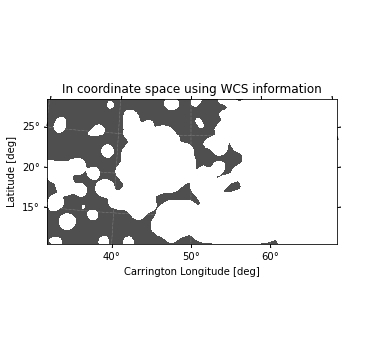
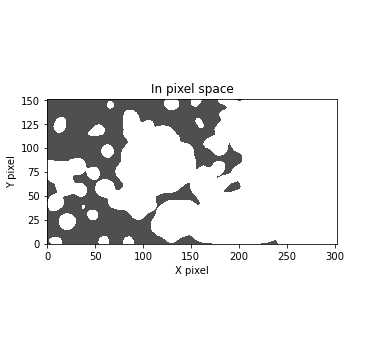
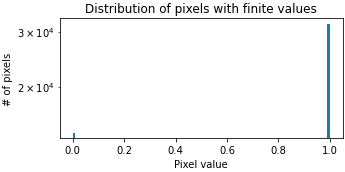

In [152]:
mdi_10001

In [41]:
# mdi_10001.fits_header['CRVAL2']

In [20]:
pos_10001_d, neg_10001_d = identify_pos_neg_region(mdi_10001, pos_gauss = 100, neg_gauss= -100)

pos_edge_10001_d = edge_detection(pos_10001_d)

neg_edge_10001_d = edge_detection(neg_10001_d)

In [40]:
# mdi_10001.top_right_coord.lon.deg

3.7872663951971504

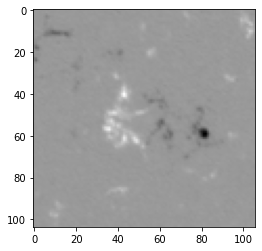

In [28]:
ax_filter_test = plt.subplot()
ax_filter_test.imshow(mdi_10001.data,cmap=plt.cm.gray)

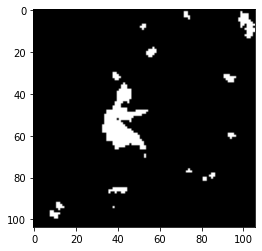

In [29]:
ax_filter_test = plt.subplot()
ax_filter_test.imshow(pos_10001_d,cmap=plt.cm.gray)

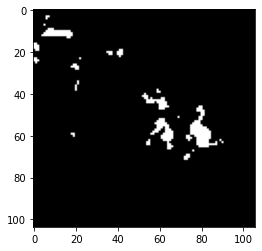

In [30]:
ax_filter_test = plt.subplot()
ax_filter_test.imshow(neg_10001_d,cmap=plt.cm.gray)

In [34]:
pos_dil_edge_10001_d = buff_edge(pos_edge_10001_d, size = 4)

neg_dil_edge_10001_d = buff_edge(neg_edge_10001_d, size = 4)

In [45]:
'aria_cea' in 'mdi.aria_bitmap_cea_2002-06-16T12_48_00_TAI.fits'

False

In [53]:
tt = 'mdi.aria_cea_2002-06-18T17:36:00_TAI.fits'.split('.')[1].split('_')[2]


In [54]:
datetime.fromisoformat(tt)

datetime.datetime(2002, 6, 18, 17, 36)

In [56]:
get_TS_mdi('mdi.aria_cea_2002-06-18T17:36:00_TAI.fits')

datetime.datetime(2002, 6, 18, 17, 36)

In [128]:
TS_mdi, mdi_map_list = get_mdi_files(9070)

In [62]:
len(mdi_map_list)

134

In [129]:
TS_mdit_n, mdi_map_n = check_SPEI(TS_mdi, mdi_map_list)

In [130]:
TS_mdit_n, mdi_map_n = patch_corner_check(TS_mdit_n, mdi_map_n)

In [131]:
len(mdi_map_n)

55

In [132]:
TS_mdi_list, mdi_PIL_series_orig_n = PIL_series(TS_mdit_n, mdi_map_n,pos_g_val = 100, neg_g_val = -100)

Success:  55
Fail:  0


In [133]:
mdi_ls_pil_orig_n,mdi_ls_label_orig_n = PIL_dataframe(mdi_PIL_series_orig_n)

In [134]:
ls_n_label = filtering_by_strength(mdi_ls_pil_orig_n, mdi_ls_label_orig_n, mdi_PIL_series_orig_n,mdi_map_n,threshold = 0.95)


In [135]:
mdi_ls_strength_binary_image, mdi_ls_thin_df, mdi_ls_thin_binary = thining_strength_label(ls_n_label)

In [136]:
mdi_ls_thin_filter_b_image = filtering_by_thinned_length(mdi_ls_thin_df, mdi_ls_thin_binary,thin_threshold = 14)

In [137]:
mdi_ls_final_b_pil,mdi_ls_final_convex_pil = ls_final_pil(mdi_ls_thin_df,mdi_ls_strength_binary_image)

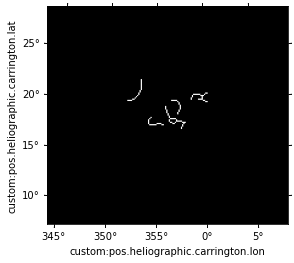

In [138]:
ax_filter_test = plt.subplot(projection = mdi_map_n[10])
ax_filter_test.imshow(mdi_ls_thin_filter_b_image[10].astype(bool),cmap=plt.cm.gray)

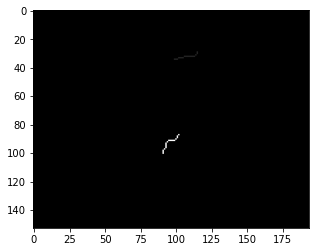

In [122]:
plt.imshow(mdi_ls_thin_filter_b_image[10],cmap=plt.cm.gray)
plt.savefig('haha.png')

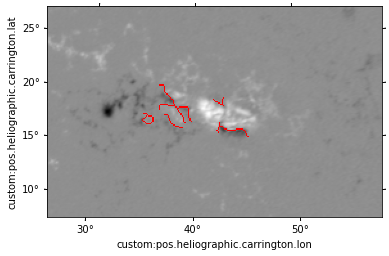

In [147]:
ax_filter_test = plt.subplot(projection = mdi_map_n[54])
masked_mdi2 = np.ma.masked_where(mdi_ls_thin_filter_b_image[54].astype(float) == 0, mdi_ls_thin_filter_b_image[54].astype(float))
# ax4 = plt.subplot(projection = hmi_map_377_magmap)
# ax4.imshow(pos_edge_377, cmap=plt.cm.gray)

ax_filter_test.imshow(mdi_map_n[54].data,cmap=plt.cm.gray)
plt.imshow(masked_mdi2.astype(bool), 'autumn', interpolation='none', alpha=1)

<sunpy.map.sources.soho.MDIMap object at 0x7ff5b1350fd0>
SunPy Map
---------
Observatory:		 SOHO
Instrument:		 MDI
Detector:		 MDI
Measurement:		 magnetogram
Wavelength:		 0.0 Angstrom
Observation Date:	 2000-07-11 00:00:01
Exposure Time:		 0.000000 s
Dimension:		 [261. 164.] pix
Coordinate System:	 heliographic_carrington
Scale:			 [0.12 0.12] deg / pix
Reference Pixel:	 [130.   81.5] pix
Reference Coord:	 [42.00387468 17.910555  ] deg                   
array([[ 26.80958797,   7.74557594,  10.64856629, ...,  20.25139784,
          1.89298424,  -7.82493572],
       [ 15.46968063,   5.52144237,   5.03868514, ...,  -2.46777476,
        -10.26313108,  -8.53709704],
       [ 21.86305572,  14.20668102,   9.89956897, ...,  -2.91283646,
        -20.07299019, -34.98289518],
       ...,
       [ 20.76550776,  26.09232903,  45.4551051 , ...,  18.74641935,
        -11.09386211, -46.70316573],
       [ -0.40022211,   5.85872122,  27.58152107, ...,  -0.85853567,
         -8.83942666, -45.12231089],
       [  3.63870409,  10.18098232, -16.61158752, ..., -55.62322353,
        -53.48466712, -33.93539334]])
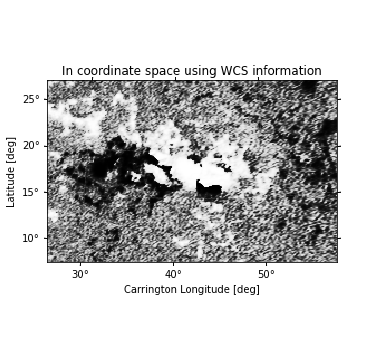
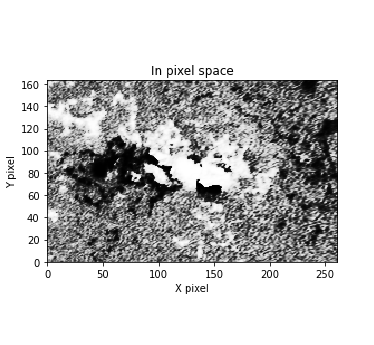
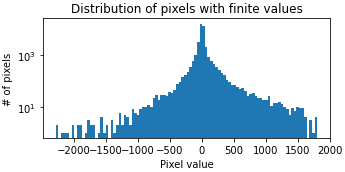

In [168]:
mdi_map_n[54]

<sunpy.map.sources.soho.MDIMap object at 0x7ff5b131c090>
SunPy Map
---------
Observatory:		 SOHO
Instrument:		 MDI
Detector:		 MDI
Measurement:		 magnetogram
Wavelength:		 0.0 Angstrom
Observation Date:	 2000-07-10 03:12:01
Exposure Time:		 0.000000 s
Dimension:		 [239. 181.] pix
Coordinate System:	 heliographic_carrington
Scale:			 [0.12 0.12] deg / pix
Reference Pixel:	 [119.  90.] pix
Reference Coord:	 [28.45793866 18.02625067] deg                   
array([[  -0.62220531,    7.64197334,    6.28414664, ...,   20.78549546,
           3.49686098,   -3.33603507],
       [ -15.12188452,  -25.64937854,   -5.15586817, ...,   19.66968311,
          28.05157837,    9.74542598],
       [  18.57807329,   -8.38869287,   -8.29754437, ...,   37.31343827,
          37.94314245,    2.36281547],
       ...,
       [   3.8692801 ,   -6.5263473 ,    0.41343109, ..., -116.11081857,
        -138.84284819, -202.64363791],
       [  11.81916953,    3.63318871,   -4.21073509, ...,  -84.16090151,
        -193.42856518, -257.70724263],
       [  -0.88122583,    6.06330358,    2.41553634, ...,  -69.2114809 ,
        -118.46065251, -210.17926411]])
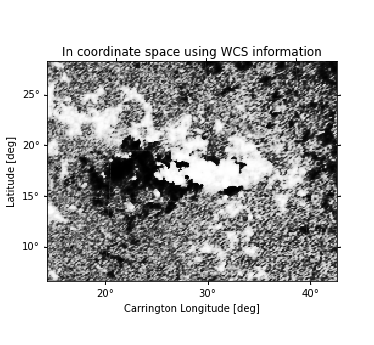
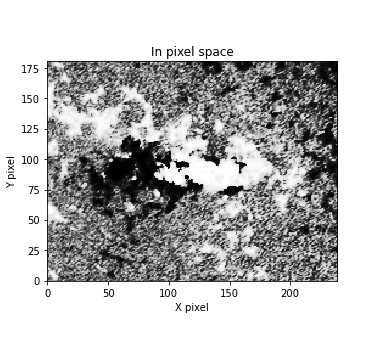
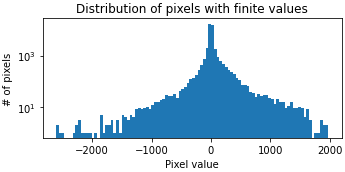

In [162]:
mdi_map_list[80]

### HMI Magnetogram

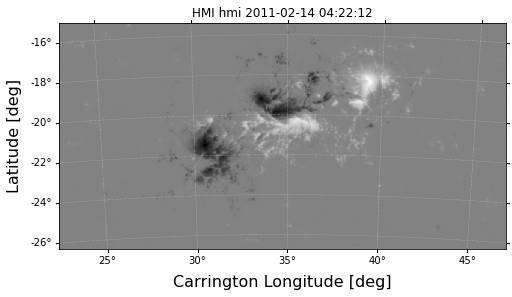

In [3]:
hmi_map_377_magmap = sunpy.map.Map('/Users/xumin/ImageProcessing/PIL_Detection_Shoeb/377/hmi.sharp_cea_720s.377.20110214_042400_TAI.magnetogram.fits')
fig = plt.figure(figsize=(8,6))

hmi_map_377_magmap.plot()
# plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377.png',dpi=300,bbox_inches='tight')

In [4]:
# import numpy as np
# from astropy.io import fits
# def load_img(filepath):
#     img = fits.open(filepath)
# #     print(len(img))
#     img = img[0]
#     return img

In [5]:
# #Downscaled harp
# harp_377_downscaled = load_img('/Users/xumin/ImageProcessing/PIL_Detection_Shoeb/Downscaled/hmi.sharp_cea_720s.377.20110221_073600_TAI.magnetogram.fits')

In [6]:
# #High resolution Harp
# harp_377_high = load_img('/Users/xumin/ImageProcessing/PIL_Detection_Shoeb/Super_resolved/hmi.sharp_cea_720s.377.20110214_220000_TAI.magnetogram.fits')

In [7]:
# harp_377_original = sunpy.map.Map('/Users/xumin/ImageProcessing/PIL_Detection_Shoeb/Original/hmi.sharp_cea_720s.377.20110221_073600_TAI.magnetogram.fits')

In [8]:
# pos_377_d, neg_377_d = identify_pos_neg_region(harp_377_high, pos_gauss = 100, neg_gauss= -100)

# pos_edge_377_d = edge_detection(pos_377_d)

# neg_edge_377_d = edge_detection(neg_377_d)

In [9]:
# (harp_377_downscaled.data * 1500).max()

In [10]:
# ax_filter_test = plt.subplot()
# ax_filter_test.imshow(neg_edge_377_d.astype(bool),cmap=plt.cm.gray)

In [11]:
# harp_377_original.plot()

In [12]:
# pos_dil_edge_377_d = buff_edge(pos_edge_377_d, size = 4)

# neg_dil_edge_377_d = buff_edge(neg_edge_377_d, size = 4)

In [13]:
# harp_377_downscaled.data.max()

In [14]:
# harp_377_high.data.max()

In [15]:
# harp_377_original.data.max()

In [16]:
# harp_377_high.shape

#### Identify Polarity Region by Strength threshold and Apply Canny Edge Detection

In [17]:
pos_377, neg_377 = identify_pos_neg_region(hmi_map_377_magmap, pos_gauss = 100, neg_gauss= -100)

pos_edge_377 = edge_detection(pos_377)

neg_edge_377 = edge_detection(neg_377)

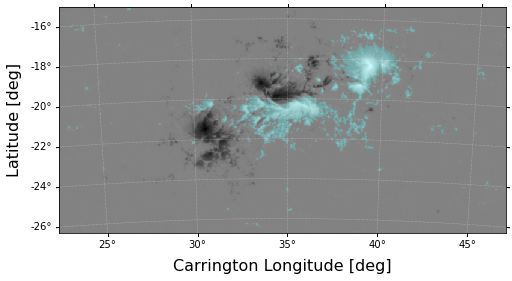

In [18]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()
masked_im0 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
plt.imshow(masked_im0, 'cool', interpolation='none', alpha=0.2)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_posregion.png',dpi=300,bbox_inches='tight')
plt.show()

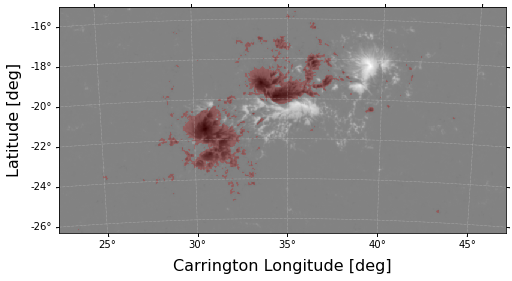

In [19]:
fig = plt.figure(figsize=(8,6))
# ax = plt.subplot()
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
# plt.xlabel('Carrington Longitude [deg]',fontsize = 18)
# plt.ylabel('Latitude [deg]',fontsize = 18)

hmi_map_377_magmap.plot()

masked_im1 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))
plt.imshow(masked_im1, 'autumn', interpolation='none', alpha=0.2)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)

# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_negregion.png',dpi=300,bbox_inches='tight')
plt.show()

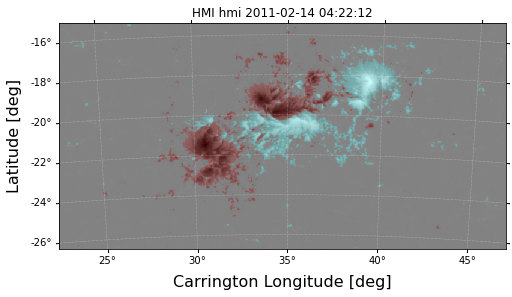

In [20]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()
masked_im0 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
masked_im1 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))

plt.imshow(masked_im0, 'cool', interpolation='none', alpha=0.2)
plt.imshow(masked_im1, 'autumn', interpolation='none', alpha=0.2)
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_binarymask.png',dpi=300,bbox_inches='tight')
plt.show()


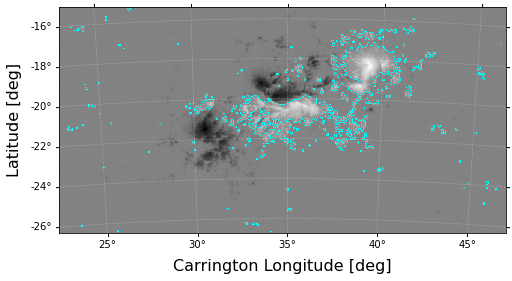

In [21]:
fig = plt.figure(figsize=(8,6))
# hmi_map_377_magmap.plot_settings['cmap'] = 'hmimag'
# hmi_map_377_magmap.plot_settings['norm'] = plt.Normalize(-1500, 1500)
# im_hmi = hmi_map_377_magmap.plot()
# cb = plt.colorbar(im_hmi, fraction=0.019, pad=0.1)
# cb.set_label("LOS Magnetic Field [Gauss]")
hmi_map_377_magmap.plot()
masked_im2 = np.ma.masked_where(pos_edge_377.astype(float) == 0, pos_edge_377.astype(float))
# ax4 = plt.subplot(projection = hmi_map_377_magmap)
# ax4.imshow(pos_edge_377, cmap=plt.cm.gray)
plt.imshow(masked_im2, 'cool', interpolation='none', alpha=1)
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
plt.title('')
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_posedge.png',dpi=300,bbox_inches='tight')
plt.show()

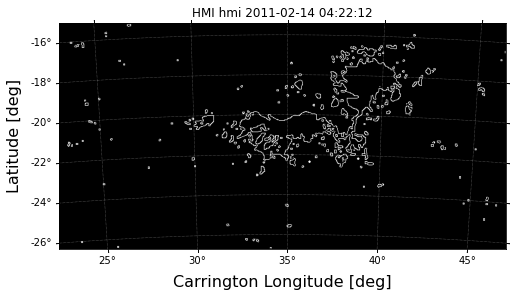

In [22]:
fig = plt.figure(figsize=(8,6))
hmi_map_377_magmap.plot()
plt.imshow(pos_edge_377.astype(bool),cmap=plt.cm.gray)
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.title('')
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_posedge_binary.png',dpi=300,bbox_inches='tight')
plt.show()

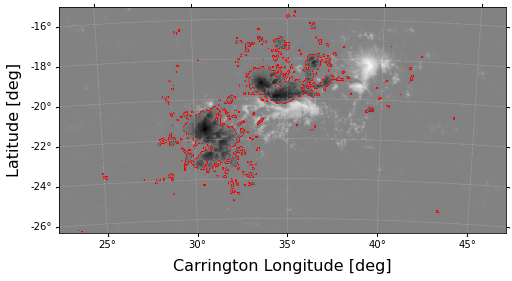

In [23]:
fig = plt.figure(figsize=(8,6))
# hmi_map_377_magmap.plot_settings['cmap'] = 'hmimag'
# hmi_map_377_magmap.plot_settings['norm'] = plt.Normalize(-1500, 1500)
# im_hmi = hmi_map_377_magmap.plot()
# cb = plt.colorbar(im_hmi, fraction=0.019, pad=0.1)
# cb.set_label("LOS Magnetic Field [Gauss]")
hmi_map_377_magmap.plot()
masked_im3 = np.ma.masked_where(neg_edge_377.astype(float) == 0, neg_edge_377.astype(float))
# ax4 = plt.subplot(projection = hmi_map_377_magmap)
# ax4.imshow(pos_edge_377, cmap=plt.cm.gray)
plt.imshow(masked_im3, 'autumn', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_negedge.png',dpi=300,bbox_inches='tight')
plt.show()

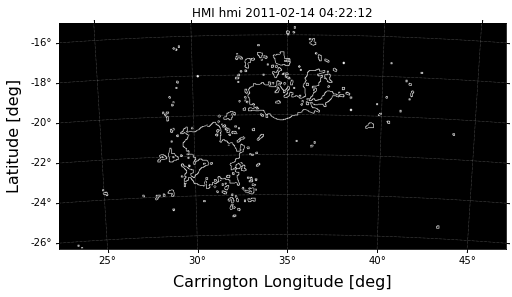

In [24]:
fig = plt.figure(figsize=(8,6))
hmi_map_377_magmap.plot()
plt.imshow(neg_edge_377.astype(bool),cmap=plt.cm.gray)
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.title('')
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_negedge_binary.png',dpi=300,bbox_inches='tight')
plt.show()

#### Extend the thickness of edge of Polarity region

In [25]:
pos_dil_edge_377 = buff_edge(pos_edge_377, size = 4)

neg_dil_edge_377 = buff_edge(neg_edge_377, size = 4)

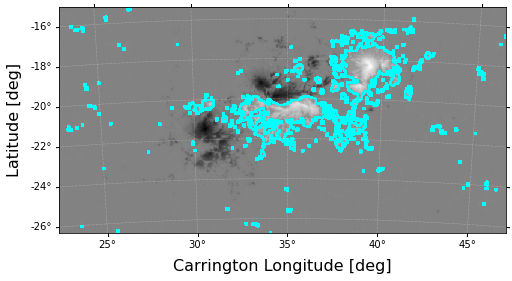

In [26]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()
masked_im4 = np.ma.masked_where(pos_dil_edge_377.astype(float) == 0, pos_dil_edge_377.astype(float))
plt.imshow(masked_im4, 'cool', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_posdiledge.png',dpi=300,bbox_inches='tight')
plt.show()

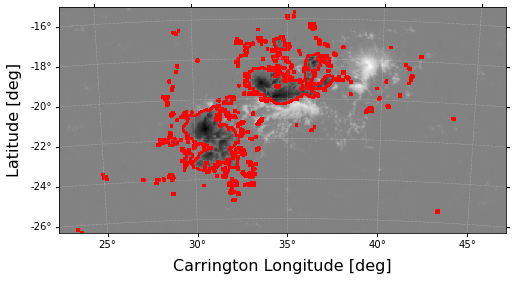

In [27]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()
masked_im5 = np.ma.masked_where(neg_dil_edge_377.astype(float) == 0, neg_dil_edge_377.astype(float))
plt.imshow(masked_im5, 'autumn', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_negdiledge.png',dpi=300,bbox_inches='tight')
plt.show()

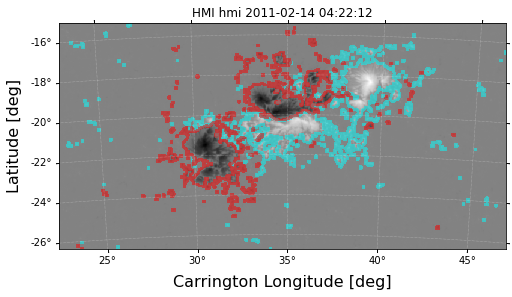

In [28]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()
# masked_im4 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
# masked_im5 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
plt.imshow(masked_im4, 'cool', interpolation='none', alpha=0.5)
plt.imshow(masked_im5, 'autumn', interpolation='none', alpha=0.5)

# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_intersectdiledge.png',dpi=300,bbox_inches='tight')
plt.show()

In [7]:
# sunpy.map.Map('/Users/xumin/ImageProcessing/raw_sharp_test/6308/hmi.sharp_cea_720s.6308.20160129_032400_TAI.magnetogram.fits')
# MapMetaValidationError: Image coordinate units for axis 1 not present in metadata.
# Image coordinate units for axis 2 not present in metadata.
# See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata` for instructions on how to add missing metadata.


In [8]:
# TS_list_orig_6308,ls_files_orig_6308 = get_magnetogram_files_twelve_min(6308)

#### HARP 377 series processing example

In [29]:
#read whole series
TS_list_orig,ls_files_orig = get_magnetogram_files_twelve_min(377)

In [30]:
#check centroid
TS_list_n, ls_files_n = check_SPEI(TS_list_orig, ls_files_orig)

In [31]:
#check corner
TS_list_n, ls_files_n = patch_corner_check(TS_list_n, ls_files_n)

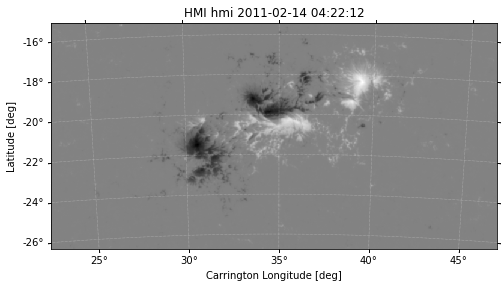

In [32]:
fig = plt.figure(figsize=(8,6))
ls_files_orig[392].plot()
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_projecteffection.png',dpi=300,bbox_inches='tight')
plt.show()

In [148]:
# def preprocess_clip(ls_files):
    
#     n_list = []
    
#     for i in ls_files:
        
#         result_pos = np.where(i.data >1500)
#         result_neg = np.where(i.data < -1500)
    
#         i.data[result_pos[0],result_pos[1]] = 1500
#         i.data[result_neg[0],result_neg[1]] = -1500
        
        
#         n_list.append(i)
        
        
#     return ls_files

In [33]:
# ls_files_n = preprocess_clip(ls_files_n)

In [34]:
# ls_files_n[395].plot()

In [35]:
# ls_files[1134].top_right_coord

In [36]:
TS_list, PIL_series_orig_n = PIL_series(TS_list_n, ls_files_n,pos_g_val = 100, neg_g_val = -100)

Success:  901
Fail:  0


In [37]:
# ls_files_n[392].data.max()

In [38]:
ls_pil_orig_n,ls_label_orig_n = PIL_dataframe(PIL_series_orig_n)

In [ ]:
#PIL before filtering based on Strength

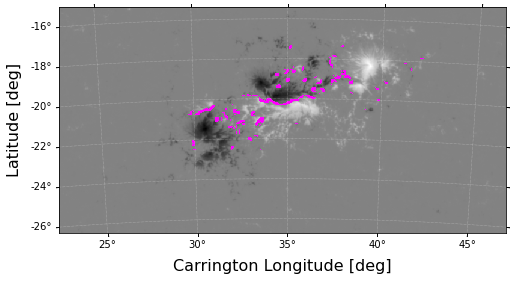

In [39]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()
masked_im6 = np.ma.masked_where(ls_label_orig_n[392].astype(bool).astype(float) == 0, ls_label_orig_n[392].astype(bool).astype(float))
plt.imshow(masked_im6, 'spring', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_RoPI_notfilter1.png',dpi=300,bbox_inches='tight')
plt.show()

# ax_orig_test = plt.subplot(projection = hmi_map_377_magmap)
# ax_orig_test.imshow(ls_label_orig_n[20].astype(bool),cmap=plt.cm.gray)

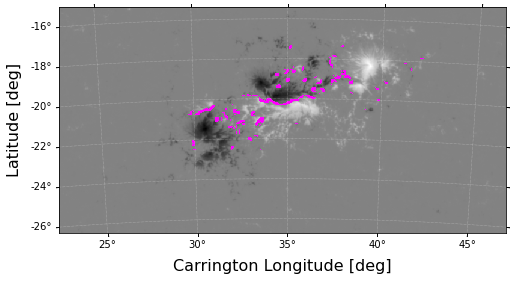

In [40]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()
masked_im6 = np.ma.masked_where(ls_label_orig_n[392].astype(bool).astype(float) == 0, ls_label_orig_n[392].astype(bool).astype(float))
plt.imshow(masked_im6, 'spring', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_RoPI_notfilter1.png',dpi=300,bbox_inches='tight')
plt.show()


In [41]:
# fig = plt.figure(figsize=(16,14))
# # ax7 = plt.subplot(projection = hmi_map_377_magmap)
# ls_files_n[392].plot()
# # masked_im4 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
# # masked_im5 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))

# plt.imshow(masked_im4, 'cool', interpolation='none', alpha=0.5)
# plt.imshow(masked_im5, 'autumn', interpolation='none', alpha=0.5)
# plt.imshow(masked_im6, 'spring', interpolation='none', alpha=0.5)
# plt.show()

In [43]:
# len(PIL_series_orig_n)

In [44]:
#Strength filter using 95%
ls_n_label = filtering_by_strength(ls_pil_orig_n, ls_label_orig_n, PIL_series_orig_n,ls_files_n,threshold = 0.95)

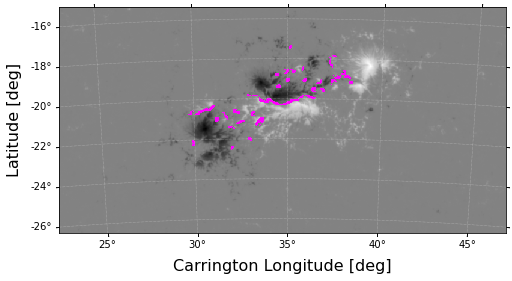

In [45]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()
masked_im7 = np.ma.masked_where(ls_n_label[392].astype(bool).astype(float) == 0, ls_n_label[392].astype(bool).astype(float))
plt.imshow(masked_im7, 'spring', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.xlim(10, 50)
# plt.ylim(30,100)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_RoPI_filtered1.png',dpi=300,bbox_inches='tight')
plt.show()

# ax_str_test = plt.subplot(projection = ls_files[392])
# ax_str_test.imshow(ls_n_label[392].astype(bool),cmap=plt.cm.gray)

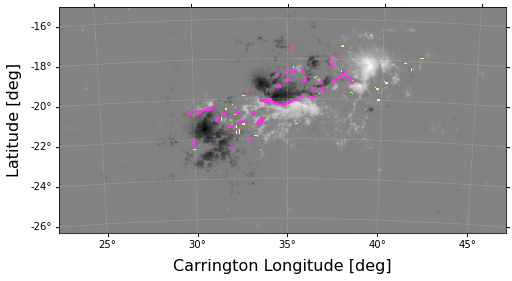

In [46]:
##Remove part based on magnetic field strength filter
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()
# masked_im4 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
# masked_im5 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))

# plt.imshow(masked_im4, 'cool', interpolation='none', alpha=0.5)
# plt.imshow(masked_im5, 'Wistia', interpolation='none', alpha=0.5)
plt.imshow(masked_im6, 'Wistia', interpolation='none', alpha=1)
plt.imshow(masked_im7, 'spring', interpolation='none', alpha=0.8)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_RoPI_remove1.pdf',dpi=300,bbox_inches='tight')
plt.show()
# plt.savefig('/Users/xumin/ImageProcessing/PIL_paper_377/magmap377.pdf'.format(harpnum,m),bbox_inches='tight')

In [ ]:
# a_test = ls_pil_4698_orig[37][ls_pil_4698_orig[37].cum_percent >0.95].label.values
# a_test

In [ ]:
# b_test = np.isin(ls_label_4698_orig[37], a_test)

# bb_test = ls_label_4698_orig[37]

# bb_test[b_test] = 0

In [ ]:
# ax_orig_filter = plt.subplot(projection = submap_4698[37])
# ax_orig_filter.imshow(b_test,cmap=plt.cm.gray)

In [47]:
ls_strength_binary_image, ls_thin_df, ls_thin_binary = thining_strength_label(ls_n_label)


NameError: name 'ls_files' is not defined

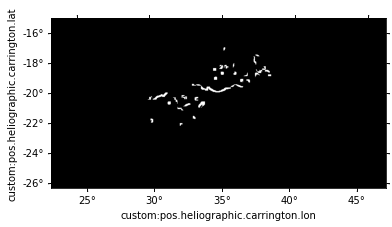

In [49]:
ax_filter_test = plt.subplot(projection = hmi_map_377_magmap)
ax_filter_test.imshow(ls_strength_binary_image[392].astype(bool),cmap=plt.cm.gray)

In [50]:
a_thin = ls_thin_binary[392].copy()

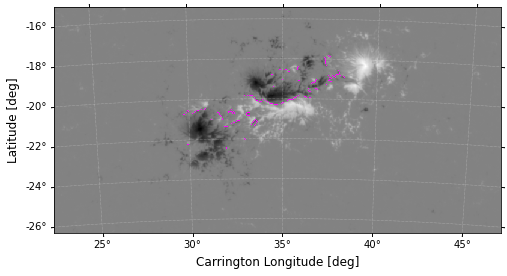

In [51]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()

masked_im8 = np.ma.masked_where(a_thin.astype(bool).astype(float) == 0, a_thin.astype(bool).astype(float))
plt.imshow(masked_im8, 'spring', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 12)
plt.ylabel('Latitude [deg]',fontsize = 12)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_thin_notfilter1.png',dpi=300,bbox_inches='tight')
plt.show()

# ax_thin_test = plt.subplot(projection = ls_files[392])
# ax_thin_test.imshow(ls_thin_binary[392].astype(bool),cmap=plt.cm.gray)

In [ ]:
#Further Filter PIL based on Length/Size (==14 pixel)

In [52]:
ls_thin_filter_b_image = filtering_by_thinned_length(ls_thin_df, ls_thin_binary,thin_threshold = 14)

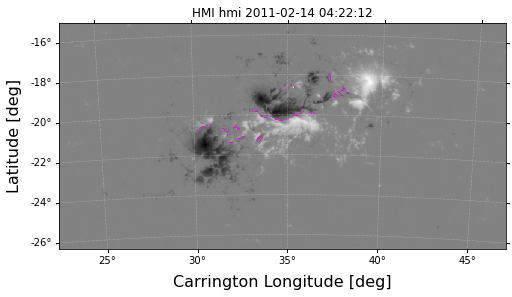

In [53]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()

masked_im9 = np.ma.masked_where(ls_thin_filter_b_image[392].astype(bool).astype(float) == 0, ls_thin_filter_b_image[460].astype(bool).astype(float))
plt.imshow(masked_im9, 'spring', interpolation='none', alpha=1)
# plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_Feb14_18:00.pdf',dpi=300,bbox_inches='tight')

plt.show()

# ax_thin_filter_test = plt.subplot(projection = ls_files[392])
# ax_thin_filter_test.imshow(ls_thin_filter_b_image[392].astype(bool),cmap=plt.cm.gray)

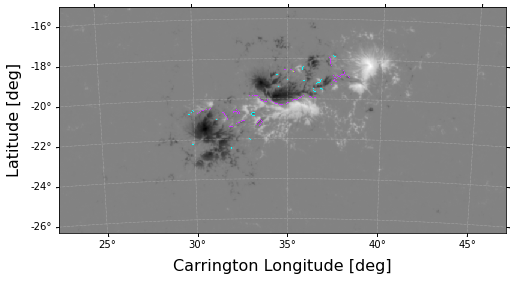

In [54]:
##Remove part based on Length filter (light green part is removed based on Length/Size filter)
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()
# masked_im4 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
# masked_im5 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))

# plt.imshow(masked_im4, 'cool', interpolation='none', alpha=0.5)
# plt.imshow(masked_im5, 'Wistia', interpolation='none', alpha=0.5)
plt.imshow(masked_im8, 'cool', interpolation='none', alpha=1)
plt.imshow(masked_im9, 'spring', interpolation='none', alpha=0.8)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_thin_remove1.png',dpi=300,bbox_inches='tight')
plt.show()

In [55]:
ls_final_b_pil,ls_final_convex_pil = ls_final_pil(ls_thin_df,ls_strength_binary_image)

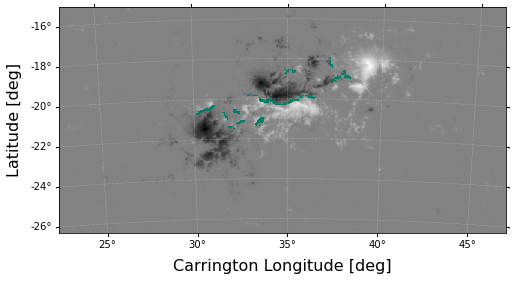

In [56]:

fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
ls_files_n[392].plot()

masked_im10 = np.ma.masked_where(ls_final_b_pil[392].astype(bool).astype(float) == 0, ls_final_b_pil[392].astype(bool).astype(float))
plt.imshow(masked_im10, 'summer', interpolation='none', alpha=1)
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
plt.title('')
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_RoPI_map.png',dpi = 300,bbox_inches='tight')
plt.show()

# ax_final_test = plt.subplot(projection = ls_files[392])
# ax_final_test.imshow(ls_final_b_pil[392].astype(bool),cmap=plt.cm.gray)

In [57]:
#convex hull df of PIL, and dataframe of convex hull PIL
ls_convex_pil_df, ls_convex_pil_thin = convex_pil_thin(ls_thin_filter_b_image)

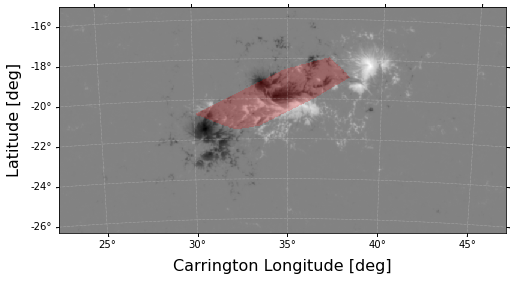

In [58]:
fig = plt.figure(figsize=(8,6))
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
hmi_map_377_magmap.plot()

masked_im11 = np.ma.masked_where(ls_convex_pil_thin[392].astype(bool).astype(float) == 0, ls_convex_pil_thin[392].astype(bool).astype(float))
plt.imshow(masked_im11, 'autumn', interpolation='none', alpha=0.2)
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
plt.title('')
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_PILconvex.png',dpi = 300,bbox_inches='tight')
plt.show()

# ax_final_convex_pil = plt.subplot(projection = ls_files[20])
# ax_final_convex_pil.imshow(ls_convex_pil_thin[20].astype(bool),cmap=plt.cm.gray)

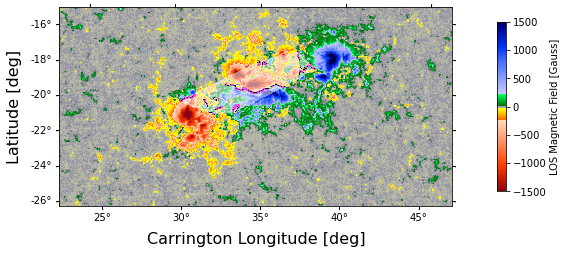

In [59]:
# masked_imPIL = np.ma.masked_where(im_PIL.astype(float) == 0, im_PIL.astype(float))
# masked_imCHPIL = np.ma.masked_where(im_CHPIL.astype(float) == 0, im_CHPIL.astype(float))
# masked_imRoPI = np.ma.masked_where(im_RoPI.astype(float) == 0, im_RoPI.astype(float))

fig = plt.figure(figsize=(8,6))
hmi_map_377_magmap.plot_settings['cmap'] = 'hmimag'
hmi_map_377_magmap.plot_settings['norm'] = plt.Normalize(-1500, 1500)
im_hmi = hmi_map_377_magmap.plot()
cb = plt.colorbar(im_hmi, fraction=0.019, pad=0.1)
cb.set_label("LOS Magnetic Field [Gauss]")


# plt.imshow(masked_imCHPIL, 'binary', interpolation='none', alpha=0.5)
# plt.imshow(masked_imRoPI, 'spring', interpolation='none', alpha=0.7)
plt.imshow(masked_im11, 'binary', interpolation='none', alpha=0.5)
plt.imshow(masked_im10, 'spring', interpolation='none', alpha=0.7)
plt.imshow(masked_im9, 'bone', interpolation='none', alpha=1)
plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_mag_str.png',dpi=300,bbox_inches='tight')
plt.show()
# plt.savefig('/Users/xumin/ImageProcessing/PIL_hybrid_377/{}_{}.png'.format(harpnum,m),bbox_inches='tight')


In [ ]:
#Binary Mask of three PIL related

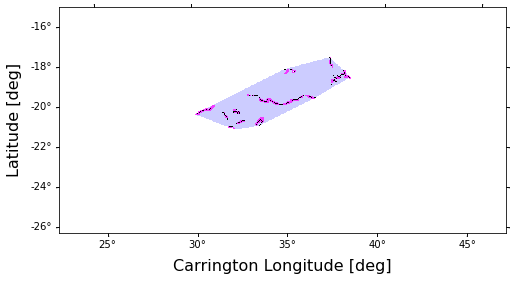

In [61]:
fig = plt.figure(figsize=(8,6))
plt.subplot(projection = hmi_map_377_magmap)
# ax7 = plt.subplot(projection = hmi_map_377_magmap)
# hmi_map_377_magmap.plot()
# masked_im4 = np.ma.masked_where(pos_377.astype(float) == 0, pos_377.astype(float))
# masked_im5 = np.ma.masked_where(neg_377.astype(float) == 0, neg_377.astype(float))

# plt.imshow(masked_im4, 'cool', interpolation='none', alpha=0.5)
# plt.imshow(masked_im5, 'Wistia', interpolation='none', alpha=0.5)
plt.imshow(masked_im11, 'winter', interpolation='none', alpha=0.2,label='Convex hull of PIL')
plt.imshow(masked_im10, 'spring', interpolation='none', alpha=0.7,label='RoPI')
plt.imshow(masked_im9, 'bone', interpolation='none', alpha=1,label='PIL')
# plt.legend()

plt.title('')
plt.xlabel('Carrington Longitude [deg]',fontsize = 16)
plt.ylabel('Latitude [deg]',fontsize = 16)
# plt.savefig('/Users/xumin/PIL_paper_377/magmap377_combined_mag_binary.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [62]:
from skimage.io import imread, imshow
im = imread('/Users/xumin/PIL_paper_377/magmap377_mag_str.png')

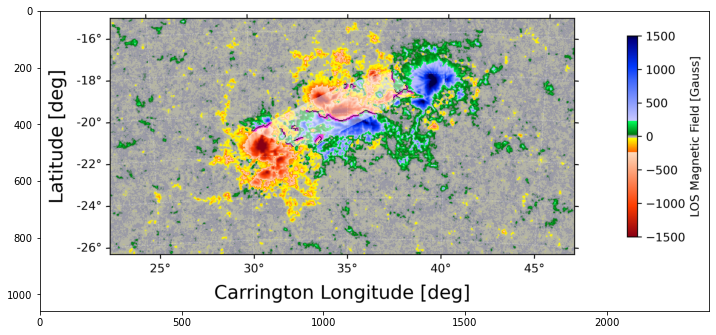

In [63]:
fig = plt.figure(figsize=(12,8))
plt.imshow(im)